# Sampling from the  sparse semi-definite positive matrix space

Here, we define a procedure to simulate a sparse semi-definite positive matrix.

We first load **matplotlib** software and enable plots embedded in the notebook (see [documentation](https://matplotlib.org/contents.html)).

In [51]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

Then, we load **StatisKit** software suite required for performing high-dimensional graph inference:

* The **StatisKit.LinAlg** software is necessary for solving linear algebra problems in *C++* and *Python*.
* The **StatisKit.Core** software is necessary for manipulating classical statistical tools in *C++* and *Python*.
* The **StatisKit.PGM** software is necessary for using probalistic graphical models in *C++* and *Python*.

In [52]:
from statiskit import (linalg,
                       core,
                       pgm)

Note that we need to set the seed from an OS' random number generator to have different results for each execution.

In [53]:
import os
seed = ord(os.urandom(1))
core.controls.set_seed(seed)

Let $K$ be the problem dimension.

In [54]:
K = int(os.environ.get('K', 10))

We use the mixture model for undirected graphs to simulate a graph $G = \left(\mathcal{V}, \mathcal{E}\right)$ denoted by `graph` in the code.
The mixture model is defined with $3$ states with

$$\alpha = \begin{pmatrix}0.05 & 0.10 & 0.85\end{pmatrix},$$

and

$$
\Pi = \begin{pmatrix}
             0.8 &  0.3 & 0.01\\
             0.3 &  0.1 & 0.01\\
            0.01 & 0.01 & 0.01\\
      \end{pmatrix}.
$$

In [55]:
%%time
process = pgm.UndirectedGraphProcess("mixture",
                                     nb_vertices=K,
                                     nb_states=3,
                                     pi = linalg.Matrix([[ 0.8,  0.3, 0.01],
                                                         [ 0.3,  0.1, 0.01],
                                                         [0.01, 0.01, 0.01]]),
                                     alpha = linalg.Vector([0.05, 0.1, 0.85]))
graph = process.simulate()
walk = os.environ.get('WALK', 'free')
if walk == 'chordal':
    if not graph.is_chordal:
        graph = graph.maximum_cardinality_embedding(True)
elif walk == 'connected':
    for v in range(1, graph.nb_vertices):
        if not graph.are_connected(v - 1, v):
            graph.has_edge(v - 1, v)
elif not walk == 'free:
    raise ValueError("'WALK' environment variable")
if not walk == 'free':
    walk = process.random_walk(walk,
                               length=K,
                               graph=graph)
    graph = walk.graph.copy()
graph.write_gml('graph.gml')

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 1.73 ms


We here represent the adjacency matrix $A$ of $G$ and $\tilde{A}$ that is a permutation of $A$ such as vertices are regrouped by their MAP assignment.

<IPython.core.display.Javascript object>


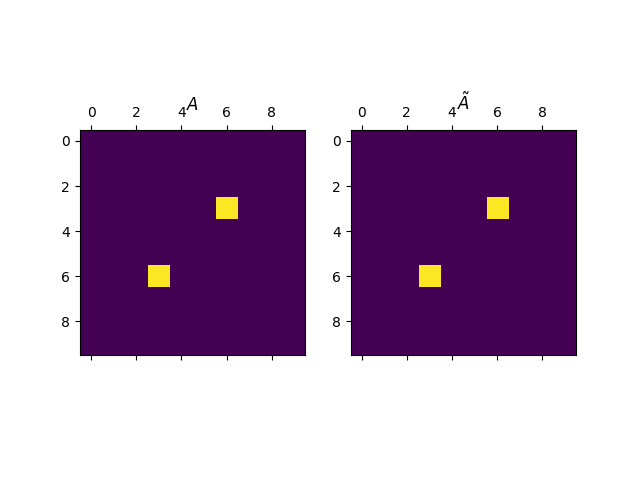

In [56]:
fig = pyplot.figure()
axes = graph.to_matrix().plot(axes = fig.add_subplot(121))
axes.set_title(r'$A$')
assigment = list(process.assignment(graph))
axes = graph.to_matrix(sort = assigment).plot(axes = fig.add_subplot(122))
axes.set_title(r'$\tilde{A}$')

To obtain a concentration matrix $\Theta$ that has the same sparsity pattern as $G$, we first simulate a covariance matrix $\Sigma$ using a [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) $W_K\left(V, K\right)$ where,
$$
    \forall \left(u, v\right) \in \mathcal{V}^2,\,
                  \begin{cases}
                      v_{u,v} = 2 & \mathrm{if}\, i = j,\\
                      v_{u,v} = 1 & \mathrm{otherwise.}\\
                  \end{cases}
$$
This matrix $\Sigma$ is the covariance matrix of the `data` variable obtained by drawing $K$ independent samples from the random vector $\boldsymbol{X} \sim \mathcal{N}\left(\boldsymbol{0}, V\right)$.

<IPython.core.display.Javascript object>


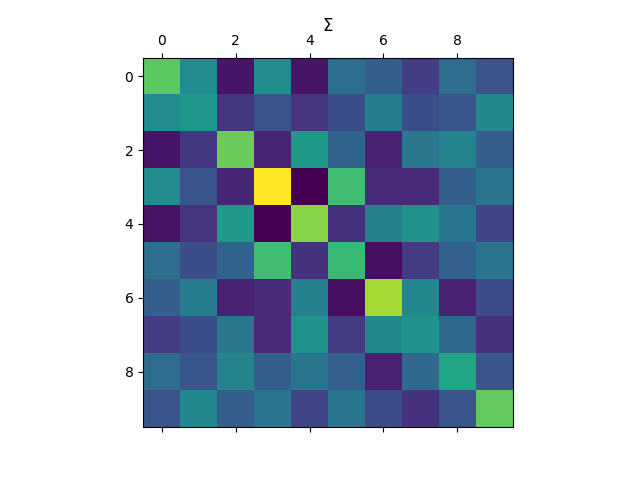

In [57]:
dist = pgm.GraphicalGaussianDistribution(linalg.Vector([0] * K),
                                         linalg.Matrix([[2 if j == i else 1 for j in range(K)] for i in range(K)]))
data = dist.simulation(K)
fig = pyplot.figure()
axes = data.covariance.plot(axes = fig.add_subplot(111))
axes.set_title('$\Sigma$')
sigma = data.covariance
#print(sigma)

Hence, the concentration matrix $\Theta$ such as for all pair $\left(u, v\right)$ of disjoint vertices of $\mathcal{V}$, $\theta_{u, v} = 0$ if, and only if, $\left(u, v\right) \not\in \mathcal{E}$ is obtained by infering the parameters of a gaussian graphical model from `data` with the graph $G$.
`algo` denotes the algorithm used for infering the parameters of a gaussian graphical model.
The possible values for `algo` are:

* `'ml'` (uniquely for chordal graphs)
* `'cd'`
* `'nr'`
* `'scd'` is an optimized version of `'cd'` taking advantage of the sparsity pattern of $\Theta$ to compute its inverse.

In [58]:
%%time
mle = pgm.graphical_gaussian_estimation(algo='scd',
                                        data=data,
                                        graph=graph)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.93 ms


As illustrated above, the estimated $\widehat{\Theta}$ concentration matrix has the same sparsity pattern has $G$ and is a semi-definite positve matrix that can be used as concentration matrix for gaussian graphical models.

<IPython.core.display.Javascript object>


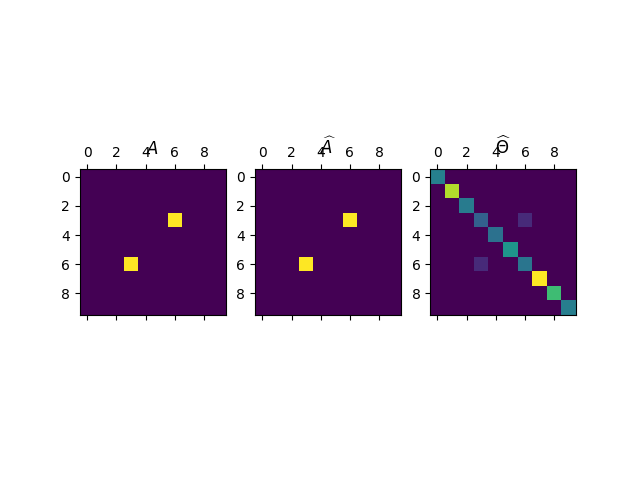

In [59]:
fig = pyplot.figure()
axes = graph.to_matrix().plot(axes = fig.add_subplot(131))
axes.set_title(r'$A$')
axes = mle.estimated.graph.to_matrix().plot(axes = fig.add_subplot(132))
axes.set_title(r'$\widehat{A}$')
axes = mle.estimated.theta.plot(axes = fig.add_subplot(133))
axes.set_title(r'$\widehat{\Theta}$')

We can therefore simulate a new data set that will be used for large-scale tests such as the study of the graphical lasso performance.

In [60]:
data = mle.estimated.simulation(K)
data.write_csv('data.csv')